In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.utils.multiclass import unique_labels

import os

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [3]:
import tensorflow as tf
from tensorflow import keras

from keras.applications import VGG19,ResNet50

'Import the datagenerator to augment images'
from keras.preprocessing.image import ImageDataGenerator

from keras.optimizers import SGD,Adam
from keras.callbacks import ReduceLROnPlateau

'Lastly import the final layers that will be added on top of the base model'
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout

'Import to_categorical from the keras utils package to one hot encode the labels'
from keras.utils import to_categorical

In [4]:
#Import dataset
from keras.datasets import cifar10

In [5]:
(x_train,y_train),(x_test,y_test)=cifar10.load_data()

170498071/170498071 [==============================] - 3s 0us/step


In [6]:
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=.3)

In [7]:
#Print the dimensions of the datasets to make sure everything's kosher

print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((35000, 32, 32, 3), (35000, 1))
((15000, 32, 32, 3), (15000, 1))
((10000, 32, 32, 3), (10000, 1))


In [7]:
#One hot encode the labels.Since we have 10 classes we should expect the shape[1] of y_train,y_val and y_test to change from 1 to 10

y_train=to_categorical(y_train)
y_val=to_categorical(y_val)
y_test=to_categorical(y_test)

In [8]:
# Lets print the dimensions one more time to see if things changed the way we expected

print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((35000, 32, 32, 3), (35000, 10))
((15000, 32, 32, 3), (15000, 10))
((10000, 32, 32, 3), (10000, 10))


## Steps for building a transfer learning model:

* Define the Data Augmentation (ImageDataGenerator) and Learning Rate Annealer (ReduceOnPlateau) functions

* Build the model (Base Model + Flatten + Dense)

* Check model summary

* Initialize Batch Size,Number of Epochs
Compile model

* Fit the model (We will use fit_generator since the data is fed to the model using an augmentation function

* Evaluate the model on test data

In [9]:
#Data Augmentation Function: Let's define an instance of the ImageDataGenerator class and set the parameters.We have to instantiate for the Train,Validation and Test datasets
train_generator = ImageDataGenerator(
                                    rotation_range=2, 
                                    horizontal_flip=True,
                                    zoom_range=.1 )

val_generator = ImageDataGenerator(
                                    rotation_range=2, 
                                    horizontal_flip=True,
                                    zoom_range=.1)

test_generator = ImageDataGenerator(
                                    rotation_range=2, 
                                    horizontal_flip= True,
                                    zoom_range=.1) 

In [10]:
#Fit the augmentation method to the data

train_generator.fit(x_train)
val_generator.fit(x_val)
test_generator.fit(x_test)

In [11]:
'''Learning Rate Annealer: The learning rate can be modified after a set number of epochs or after a certain condition is met. We will use the latter and change the learning rate if 
the validation error does not reduce after a set number of epochs. To do this we will use the patience parameter.'''

lrr= ReduceLROnPlateau(
    monitor='val_loss', #Metric to be measured
    factor=.01, #Factor by which learning rate will be reduced
    patience=3,  #No. of epochs after which if there is no improvement in the val_accuracy, the learning rate is reduced
    min_lr=1e-5) #The minimum learning rate 

In [12]:
#Build the model

'''The first base model used is VGG19. The pretrained weights from the
 imagenet challenge are used'''
base_model_1 = VGG19(include_top=False,weights='imagenet',input_shape=(32,32,3),
                     classes=y_train.shape[1])

'''For the 2nd base model we will use Resnet 50 and compare the
 performance against the previous one.'''
base_model_2 = ResNet50(include_top=False,weights='imagenet',input_shape=(32,32,3),
                        classes=y_train.shape[1])

94765736/94765736 [==============================] - 0s 0us/step


In [13]:
#Lets add the final layers to these base models where the actual classification is done in the dense layers

model_1= keras.Sequential()
model_1.add(base_model_1) #Adds the base model (in this case vgg19 to model_1)
model_1.add(Flatten()) #Since the output before the flatten layer is a matrix we have to use this function to get a vector of the form nX1 to feed it into the fully connected layers

In [14]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
Total params: 20,024,384
Trainable params: 20,024,384
Non-trainable params: 0
_________________________________________________________________


In [15]:
#Add the Dense layers along with activation and batch normalization
model_1.add(Dense(1024,activation=('relu'),input_dim=512))
model_1.add(Dense(512,activation=('relu'))) 
model_1.add(Dense(256,activation=('relu'))) 
#model_1.add(Dropout(.3))#Adding a dropout layer that will randomly drop 30% of the weights
model_1.add(Dense(128,activation=('relu')))
#model_1.add(Dropout(.2))
model_1.add(Dense(10,activation=('softmax'))) #This is the classification layer

In [16]:
#Check final model summary
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 10)                1

In [17]:
batch_size= 128
epochs=20

In [18]:
learn_rate=.001

sgd=SGD(learning_rate=learn_rate)
adam=Adam(learning_rate=learn_rate)

In [19]:
#Compile the model
#During model compiling the 3 main things we specify are loss function,optimizer and the metrics that need to be evaluated during the test and train processes.
#Lets start by using the SGD optimizer
#We will specify the loss as categoricl crossentropy since the labels are 1 hot encoded. IF we had integer labels,we'd have to use sparse categorical crossentropy as loss function.
model_1.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

In [20]:
model_1.fit(train_generator.flow(x_train,y_train,batch_size=batch_size),
                      epochs=epochs,
                      steps_per_epoch=x_train.shape[0]//batch_size,
                      validation_data=val_generator.flow(x_val,y_val,batch_size=batch_size),
                      validation_steps=x_test.shape[0]//batch_size,
                      callbacks=[lrr],verbose=1)

Epoch 1/20
273/273 [==============================] - 36s 95ms/step - loss: 1.4818 - accuracy: 0.4874 - val_loss: 1.0886 - val_accuracy: 0.6177 - lr: 0.0010
Epoch 2/20
273/273 [==============================] - 25s 92ms/step - loss: 1.0078 - accuracy: 0.6453 - val_loss: 0.9087 - val_accuracy: 0.6884 - lr: 0.0010
Epoch 3/20
273/273 [==============================] - 25s 92ms/step - loss: 0.8739 - accuracy: 0.6972 - val_loss: 0.8364 - val_accuracy: 0.7150 - lr: 0.0010
Epoch 4/20
273/273 [==============================] - 25s 92ms/step - loss: 0.7970 - accuracy: 0.7245 - val_loss: 0.8516 - val_accuracy: 0.7112 - lr: 0.0010
Epoch 5/20
273/273 [==============================] - 26s 96ms/step - loss: 0.7394 - accuracy: 0.7433 - val_loss: 0.7533 - val_accuracy: 0.7453 - lr: 0.0010
Epoch 6/20
273/273 [==============================] - 26s 93ms/step - loss: 0.6945 - accuracy: 0.7587 - val_loss: 0.7221 - val_accuracy: 0.7536 - lr: 0.0010
Epoch 7/20
273/273 [==============================] - 26s 

In [21]:
!nvidia-smi

Wed Nov 30 15:19:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    29W /  70W |   4978MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [22]:
metrics = pd.DataFrame(model_1.history.history)

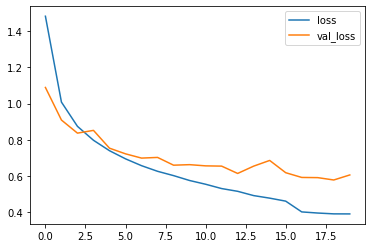

In [23]:
metrics[['loss', 'val_loss']].plot()

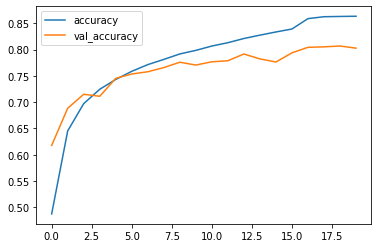

In [24]:
metrics[['accuracy', 'val_accuracy']].plot()

In [25]:
def plot_confusion_matrix(y_true, y_pred, classes):
  y_pred = [np.argmax(x, axis=0) for x in y_pred]
  y_true = [np.argmax(x, axis=0) for x in y_true]
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(cm, xticklabels=classes, yticklabels=classes, annot=True)

In [26]:
class_names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [27]:
y_pred=model_1.predict(x_test)
y_true=y_test

313/313 [==============================] - 4s 11ms/step


In [28]:
model_1.evaluate(x_test, y_test)

313/313 [==============================] - 4s 12ms/step - loss: 0.5896 - accuracy: 0.8101


[0.5895665884017944, 0.8101000189781189]

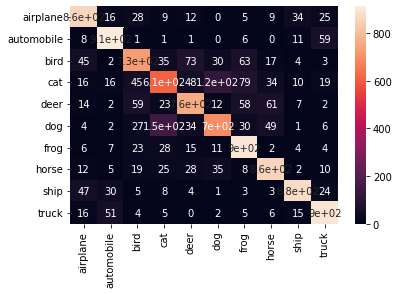

In [29]:
plot_confusion_matrix(y_true, y_pred, classes=class_names)

In [30]:
#Since we have already defined Resnet50 as base_model_2, let us build the sequential model.

model_2 = keras.Sequential()
#Add the Dense layers along with activation and batch normalization
model_2.add(base_model_2)
model_2.add(Flatten())


#Add the Dense layers along with activation and batch normalization
model_2.add(Dense(4000,activation=('relu'),input_dim=512))
model_2.add(Dense(2000,activation=('relu'))) 
model_2.add(Dropout(.4))
model_2.add(Dense(1000,activation=('relu'))) 
model_2.add(Dropout(.3))#Adding a dropout layer that will randomly drop 30% of the weights
model_2.add(Dense(500,activation=('relu')))
model_2.add(Dropout(.2))
model_2.add(Dense(10,activation=('softmax'))) #This is the classification layer

In [31]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_5 (Dense)             (None, 4000)              8196000   
                                                                 
 dense_6 (Dense)             (None, 2000)              8002000   
                                                                 
 dropout (Dropout)           (None, 2000)              0         
                                                                 
 dense_7 (Dense)             (None, 1000)              2001000   
                                                                 
 dropout_1 (Dropout)         (None, 1000)             

In [32]:
#Compile the model 

model_2.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

In [33]:
model_2.fit(train_generator.flow(x_train,y_train,batch_size=batch_size),
                      epochs=epochs,
                      steps_per_epoch=x_train.shape[0]//batch_size,
                      validation_data=val_generator.flow(x_val,y_val,batch_size=batch_size),
                      validation_steps=x_test.shape[0]//batch_size,
                      callbacks=[lrr],verbose=1)

Epoch 1/20
273/273 [==============================] - 36s 105ms/step - loss: 1.7925 - accuracy: 0.3603 - val_loss: 3.3687 - val_accuracy: 0.3496 - lr: 0.0010
Epoch 2/20
273/273 [==============================] - 27s 99ms/step - loss: 1.0982 - accuracy: 0.6374 - val_loss: 1.6990 - val_accuracy: 0.5035 - lr: 0.0010
Epoch 3/20
273/273 [==============================] - 27s 97ms/step - loss: 0.9307 - accuracy: 0.7011 - val_loss: 1.4637 - val_accuracy: 0.5940 - lr: 0.0010
Epoch 4/20
273/273 [==============================] - 27s 98ms/step - loss: 0.8050 - accuracy: 0.7408 - val_loss: 1.3049 - val_accuracy: 0.6487 - lr: 0.0010
Epoch 5/20
273/273 [==============================] - 27s 97ms/step - loss: 0.7370 - accuracy: 0.7664 - val_loss: 0.9576 - val_accuracy: 0.7103 - lr: 0.0010
Epoch 6/20
273/273 [==============================] - 27s 98ms/step - loss: 0.6869 - accuracy: 0.7820 - val_loss: 0.9578 - val_accuracy: 0.7014 - lr: 0.0010
Epoch 7/20
273/273 [==============================] - 27s

In [34]:
metrics = pd.DataFrame(model_2.history.history)

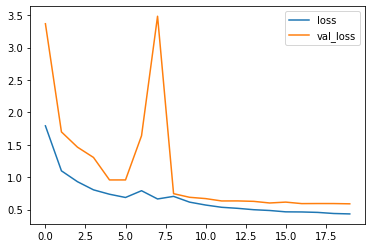

In [35]:
metrics[['loss', 'val_loss']].plot()

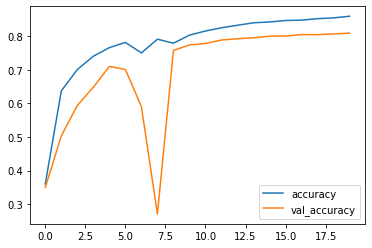

In [36]:
metrics[['accuracy', 'val_accuracy']].plot()

In [37]:
y_pred=model_2.predict(x_test)
y_true=y_test

313/313 [==============================] - 5s 12ms/step


In [38]:
model_2.evaluate(x_test, y_test)

313/313 [==============================] - 5s 14ms/step - loss: 0.6155 - accuracy: 0.8038


[0.6155380010604858, 0.8037999868392944]

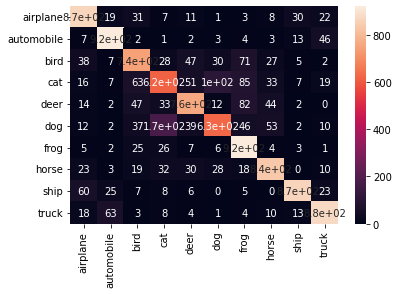

In [39]:
plot_confusion_matrix(y_true, y_pred, classes=class_names)

In [40]:
def predict_classes(model, image):
  image = image.reshape(1, 32, 32, 3)
  prediction = model.predict(image)
  return np.argmax(prediction, axis=1)

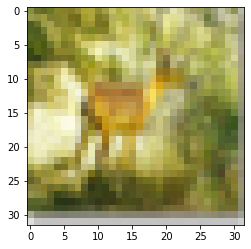

In [41]:
plt.imshow(x_test[500])

In [42]:
def get_class(y):
  return np.argmax(y, axis=0)
  

In [43]:
get_class(y_test[500])

4

In [44]:
predict_classes(model_1, x_test[500])

1/1 [==============================] - 0s 306ms/step


array([4])

In [45]:
predict_classes(model_2, x_test[500])

1/1 [==============================] - 0s 378ms/step


array([4])

In [46]:
!pip list

Package                       Version
----------------------------- ----------------------
absl-py                       1.3.0
aeppl                         0.0.33
aesara                        2.7.9
aiohttp                       3.8.3
aiosignal                     1.3.1
alabaster                     0.7.12
albumentations                1.2.1
altair                        4.2.0
appdirs                       1.4.4
arviz                         0.12.1
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
async-timeout                 4.0.2
asynctest                     0.13.0
atari-py                      0.2.9
atomicwrites                  1.4.1
attrs                         22.1.0
audioread                     3.0.0
autograd                      1.5
Babel                         2.11.0
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        5.0.1
blis                          0.7.9
bokeh

In [47]:
from tensorflow.keras.models import load_model

In [48]:
model_1.save("vgg_80.h5")

In [49]:
a= load_model("vgg_80.h5")

In [50]:
a.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 10)                1